In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau  
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

### Dataset customisée par entraîner un modèle d'auto encodeur

In [2]:
class AE_Dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data):

        super(AE_Dataset,self).__init__()
        
        #La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif 
        #de l'auto encodeur c'est de reconstituer la donnée initiale

        self.data = np.copy(data)
        self.targets = np.copy(data)

        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=torch.float32), torch.tensor(self.targets[index],dtype=torch.float32)
        

In [3]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

In [4]:
class CustomDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):
        
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler
        
        self.data = None
        self.target = None

        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()

        self.xtrain = self._xtrain # ce sont uniquement les données normales quui seront entraînées avec l'auto encoder
        self.ytrain = self.xtrain # La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif 
                                # de l'auto encodeur c'est de reconstituer la donnée initiale

        self.xtest = pd.concat([self._xtest, self.data[self.target==1]], axis=0)
        self.ytest = pd.concat([self._ytest, self.target[self.target==1]], axis=0)

        self.xtest.reset_index(drop=True, inplace=True)
        self.ytest.reset_index(drop=True, inplace=True)

        # Note : ytrain utilisé comme target lors de l'entraînement n'est le même format que ytest utilisé lors de la prédiction
        # ytrain =xtrain alors que ytest =target (labels)(0 pour donnée normale et 1 pour donnée anormale)
   
        
    def get_scaler(self):
        return self.scaler
        
    def _load_data(self):
        self.data = pd.read_csv(self.file_path)
        
        self.data.drop_duplicates(keep="last", inplace=True)
        self.target = self.data["Class"]
        self.data.drop(["Class", "Time"], axis=1,inplace=True)
        

    def _preprocess_data(self):

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        if self.scaler is not None:
            
            data_scaled_array = self.scaler.fit_transform(self.data)
            
            self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns,index=self.data.index)
            

    def _split_data(self):
        
        self._xtrain, self._xtest, self._ytrain, self._ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

## Encoder Layer

In [5]:
class Encoder(nn.Module):

    def __init__(self,input_size: int, latent_size: int,dropout: float) -> None:

        super(Encoder,self).__init__()
        
        self.fc1=nn.Linear(in_features=input_size,out_features=25)
        self.residual1=nn.Linear(in_features=input_size,out_features=20)
        self.layer_norm1=nn.LayerNorm(25)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=25,out_features=20)
        self.layer_norm2=nn.LayerNorm(20)
        self.relu2=nn.ReLU()
        self.residual2=nn.Linear(in_features=20,out_features=latent_size)
        self.fc3=nn.Linear(in_features=20,out_features=15)
        self.layer_norm3=nn.LayerNorm(15)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=15,out_features=latent_size)
        

    def forward(self,inputs: Tensor) -> Tensor:
        
        x=self.relu1(self.layer_norm1(self.fc1(inputs)))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm2(self.fc2(x)+residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm3(self.fc3(x)))
        x=self.dropout2(x)
        x=self=self.fc4(x) +residual2

        return x


## Decoder Layers

In [6]:
class Decoder(nn.Module):

    def __init__(self,latent_size: int, output_size: int,dropout: float) -> None:

        super(Decoder,self).__init__()
        
        self.fc1=nn.Linear(in_features=latent_size,out_features=15)
        self.residual1=nn.Linear(in_features=latent_size,out_features=20)
        self.relu1=nn.LeakyReLU(0.1)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=15,out_features=20)
        self.layer_norm3=nn.LayerNorm(20)
        self.relu2=nn.LeakyReLU(0.1)
        self.residual2=nn.Linear(in_features=20,out_features=29)
        self.fc3=nn.Linear(in_features=20,out_features=25)
        self.layer_norm4=nn.LayerNorm(25)
        self.relu3=nn.LeakyReLU(0.1)
        self.dropout2=nn.Dropout(dropout)
        
        self.fc4=nn.Linear(in_features=25,out_features=output_size)
        
        


    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.fc1(inputs))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm3(self.fc2(x) +residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm4(self.fc3(x)))
        x=self.dropout2(x)
        x=self=self.fc4(x) +residual2

        return x

## AutoEncoder/ Generator

In [7]:
class AutoEncoder(nn.Module):

    def __init__(self,input_size: int,latent_size: int,output_size: int,dropout: float) -> None:

        super(AutoEncoder,self).__init__()
        
        self.encoder=Encoder(input_size=input_size, latent_size = latent_size,dropout=dropout)
        self.latent=None
        self.decoder=Decoder(latent_size =latent_size, output_size=output_size,dropout=dropout)
        

        self.train_curve=[]
        self.val_curve=[]

        

    def forward(self,inputs: Tensor) -> Tensor:
        x=self.encoder(inputs)
        self.latent=x
        x=self.decoder(x)

        return x

## Discriminator

In [8]:
class Discriminator(nn.Module):

    def __init__(self,input_size: int,dropout: float) -> None:

        super(Discriminator,self).__init__()
        
        self.fc1=nn.Linear(in_features=input_size,out_features=25)
        self.residual1=nn.Linear(in_features=input_size,out_features=20)
        self.layer_norm1=nn.LayerNorm(25)
        self.relu1=nn.LeakyReLU(0.2)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=25,out_features=20)
        self.layer_norm2=nn.LayerNorm(20)
        self.relu2=nn.LeakyReLU(0.2)
        self.residual2=nn.Linear(in_features=20,out_features=5)
        self.fc3=nn.Linear(in_features=20,out_features=15)
        self.layer_norm3=nn.LayerNorm(15)
        self.relu3=nn.LeakyReLU(0.2)
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=15,out_features=5)
        self.fc5=nn.Linear(in_features=5,out_features=1)
        self.sigmoid=nn.Sigmoid()
        


    def forward(self,inputs: Tensor) -> Tensor:
        
        x=self.relu1(self.layer_norm1(self.fc1(inputs)))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm2(self.fc2(x)+residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm3(self.fc3(x)))
        x=self.dropout2(x)
        out=self.fc4(x) +residual2
        x=self.fc5(out)
        x=self.sigmoid(x)

        return out,x


## GANomaly

In [9]:
class GANomaly(nn.Module):

    def __init__(self,input_size: int,latent_size: int,contamination: float=0.02,dropout: float=0.1,device: str="cuda") -> None:

        super(GANomaly,self).__init__()
        
        self.generator = AutoEncoder(input_size=input_size,latent_size=latent_size,output_size=input_size,dropout=dropout) 
        self.discriminator=Discriminator(input_size=input_size,dropout=dropout)
        self.encoder=Encoder(input_size=input_size, latent_size = latent_size,dropout=dropout)
        self.latent_size=latent_size
        self.offset=contamination
        self.epoch=1
        
        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")
        self.is_fitted=False

        self.generator_loss=[]
        self.discriminator_loss=[]
        self.encoder_loss=[]

    def forward(self,inputs: Tensor) -> Tensor:
        pass

    
    def train_one_epoch(self,train_loader:DataLoader,Gen_optimizer,Discr_optimizer,Enc_optimizer,loss_fn,recons_loss,Gen_scheduler,En_scheduler):
        
        """The function is use to train one epoch of the model
            Args: 
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader
                
        """
        last_disc_loss=0 # Computing loss per batch
        last_gen_loss=0
        last_enc_loss=0
        running_enc_loss=0
        running_discr_loss=0
        running_gen_loss=0
        
        
        for batch_index, batch in enumerate(train_loader):


            ##--------------------------------------Entrainement du Discriminateur -------------------------------------------------------------
            
            Discr_optimizer.zero_grad()
            #real data
            real_data,target=batch[0].to(self.device),batch[1].to(self.device)

            #Fake data
            fake_data=self.generator.forward(real_data)

            batch_size=real_data.shape[0]

            #Forwards pass and loss computing for real data
            real_outputs,_=self.discriminator.forward(real_data)
            fake_output,_=self.discriminator.forward(fake_data)
            disc_loss=loss_fn(real_outputs.to(self.device),fake_output) # Computing the loss
            disc_loss.backward() # Computing the gradient

            running_discr_loss+=disc_loss.item()

            Discr_optimizer.step()
            

            ##--------------------------------------Entrainement du L'encoder -------------------------------------------------------------

            Enc_optimizer.zero_grad()
            
            fake_data1=self.generator.forward(real_data)
            z_real1=self.generator.latent
            z_fake1=self.encoder(fake_data1)

            assert z_real1.shape==z_fake1.shape, "z_real and z_fake should have the same shape"
            
            enc_loss=loss_fn(z_real1,z_fake1)
            enc_loss.backward()

            running_enc_loss+=enc_loss.item()

            Enc_optimizer.step()
            

            ##--------------------------------------Entrainement du Generateur ------------------------------------------------------------
            # Discr_optimizer.zero_grad()
            # Enc_optimizer.zero_grad()
            Gen_optimizer.zero_grad()

            fake_data2=self.generator.forward(real_data)
            z_real2=self.generator.latent
            z_fake2=self.encoder(fake_data2)
            real_outputs2,_=self.discriminator.forward(real_data)
            fake_output2,_=self.discriminator.forward(fake_data2)
            gen_loss= 1*loss_fn(z_real2,z_fake2) + 3*loss_fn(real_outputs2.to(self.device),fake_output2) + 40*recons_loss(real_data,fake_data2) # selon le document officieel

            gen_loss.backward()

            running_gen_loss+=gen_loss.item()

            Gen_optimizer.step()
            # Gen_optimizer.zero_grad()
            


            if batch_index%100==99:
                last_disc_loss=running_discr_loss/100 # Computing loss per batch
                last_gen_loss=running_gen_loss/100
                last_enc_loss=running_enc_loss/100
                
                running_discr_loss=0
                running_gen_loss=0
                running_enc_loss=0
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        # 
        if self.epoch %10==0:
            # before_lr = Gen_optimizer.param_groups[0]["lr"]
            Gen_scheduler.step()
            En_scheduler.step()
            # after_lr = Gen_optimizer.param_groups[0]["lr"]
            # print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_gen_loss,last_disc_loss,last_enc_loss
    
    def predict(self, dataloader: DataLoader, contamination: float=0.02, criterion=nn.L1Loss(reduction='none')):
        assert self.is_fitted==True, "Le modèle n'est pas encore entraîné donc ne peut pas faire de prédiction"

        self.offset=contamination
        return self.decision_function(dataloader,criterion)


    def decision_function(self,dataloader: DataLoader,loss_fn):
        
        dataframe=self.compute_score_sample(dataloader,loss_fn)
        dataframe.loc[-dataframe["score_sample"] < (-dataframe["score_sample"]).quantile(self.offset), "label"] = -1
        
        return dataframe['label']

    def score_sample(self,dataloader: DataLoader,loss_fn):
        
        dataframe=self.compute_score_sample(self,dataloader,loss_fn)

        return dataframe["score_sample"]

   
    def compute_score_sample(self,dataloader: DataLoader,loss_fn):
        
        reconstition_errors=[]
        with torch.no_grad() :
            for batch in dataloader:
    
                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self.generator.forward(data) 

                z_g_e=self.generator.latent
                z_enc=self.encoder(data)

                
                loss=loss_fn(z_enc,z_g_e) # Computing the loss

                for item in loss:
                    reconstition_errors.append(torch.sum(item).item())

        scaler=MinMaxScaler()
        recons_scaled=scaler.fit_transform(np.array(reconstition_errors).reshape(-1,1))
        reconstition_errors=list(recons_scaled.reshape(-1))
        dataframe=pd.DataFrame({
            "score_sample" : reconstition_errors,
            "label" :[1 for _ in range(len(reconstition_errors))]
        })

        return dataframe

    
    def getEpoch(self):
        return self.epoch
        
    def fit(self,train_loader,Gen_optimizer,Disc_optimizer,Enc_optimizer,Gen_scheduler,En_scheduler,loss_fn=nn.MSELoss,recons_loss=nn.L1Loss,epochs=10,device="cuda"):
        self.epoch=epochs
        """The function is used to train the model through many epochs
            Args: 
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return
                
        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
        
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss_gen,avg_loss_disc,avg_loss_enc=self.train_one_epoch(train_loader,Gen_optimizer,Disc_optimizer,Enc_optimizer,loss_fn,recons_loss,Gen_scheduler,En_scheduler) # training the model on an epoch
            
            print(f"Gen Loss {avg_loss_gen} vs Disc Loss  {avg_loss_disc} vs Enc Loss {avg_loss_enc}")
            self.generator_loss.append(avg_loss_gen)
            self.discriminator_loss.append(avg_loss_disc)
            self.encoder_loss.append(avg_loss_enc)

            if avg_loss_disc < best_avg_vloss :
                best_avg_vloss=avg_loss_disc
                model_path='/home/dah/anomalie_detection/anomalie_detection/models/model_GANomaly_{}'.format(datetime.now().strftime('%Y%m%d_%H%')) 
                torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
            self.epoch+=1
        self.is_fitted=True

        return {
            "generator_loss":self.generator_loss,
            "discriminator_loss":self.discriminator_loss,
            "encoder_loss":self.encoder_loss
        }
                

In [10]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset 
dataset = CustomDataset(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv",scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=GANomaly(input_size=29,latent_size=10,contamination=0.02,dropout=0.2,device="cpu")

#Optimiseur du generator
Gen_optimizer=optim.RMSprop(lr=1e-3, params=model.generator.parameters()) # Optimiseur

Gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(Gen_optimizer, gamma=0.1)

#Optimiseur du generator
Disc_optimizer=optim.SGD(lr=1e-3, params=model.discriminator.parameters(),momentum=0.9) # Optimiseur

#Optimiseur du generator de l'encoder
lr = 1e-4
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
Enc_optimizer=optim.RMSprop(lr=lr, params=model.encoder.parameters()) # Optimiseur
En_scheduler = torch.optim.lr_scheduler.ExponentialLR(Enc_optimizer, gamma=0.1)

# Permet de changer le learning rate au cours de l'apprentissage
# Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.L1Loss() # La fonction de perte
recons_loss=nn.SmoothL1Loss()
# recons_loss=nn.MSELoss()

history=model.fit(train_loader,Gen_optimizer,Disc_optimizer,Enc_optimizer,Gen_scheduler,En_scheduler,loss_fn,recons_loss,epochs=41)#Entraînement du modèle


EPOCHS : 1
Gen Loss 0.05802257407456637 vs Disc Loss  0.0053448526840657 vs Enc Loss 0.0101371462456882
EPOCHS : 2
Gen Loss 0.041334807015955446 vs Disc Loss  0.0029985910770483314 vs Enc Loss 0.006282441522926092
EPOCHS : 3
Gen Loss 0.034351070765405896 vs Disc Loss  0.0021640205709263683 vs Enc Loss 0.005672067436389625
EPOCHS : 4
Gen Loss 0.029088273253291844 vs Disc Loss  0.001628275290131569 vs Enc Loss 0.004750572138000279
EPOCHS : 5
Gen Loss 0.025808497238904236 vs Disc Loss  0.00131266558310017 vs Enc Loss 0.00431589366402477
EPOCHS : 6
Gen Loss 0.023973294105380773 vs Disc Loss  0.001134340116987005 vs Enc Loss 0.004179377204272896
EPOCHS : 7
Gen Loss 0.022106544487178324 vs Disc Loss  0.0009834925713948905 vs Enc Loss 0.0037670656316913663
EPOCHS : 8
Gen Loss 0.020842103492468594 vs Disc Loss  0.0008878218138124793 vs Enc Loss 0.0034324396797455847
EPOCHS : 9
Gen Loss 0.019599562594667077 vs Disc Loss  0.0007959704461973161 vs Enc Loss 0.0032523666718043387
EPOCHS : 10
Gen Lo

### Visualisation des des learnings curves sur le jeu de données d'entraînement et de validation.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

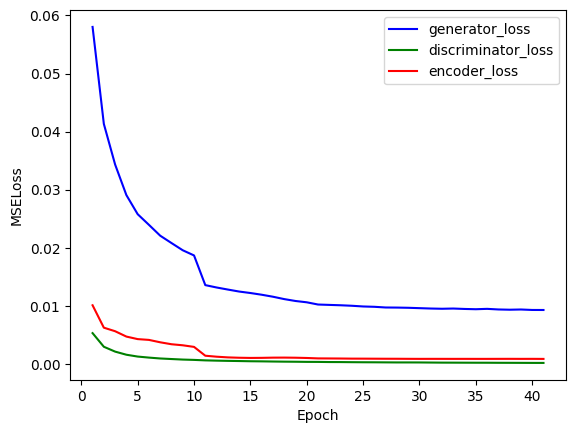

In [11]:
n=len(history['generator_loss'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['generator_loss'],label="generator_loss",color='blue')
plt.plot(epoch,history['discriminator_loss'],label="discriminator_loss",color='green')
plt.plot(epoch,history['encoder_loss'],label="encoder_loss",color='red')

plt.ylabel("MSELoss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

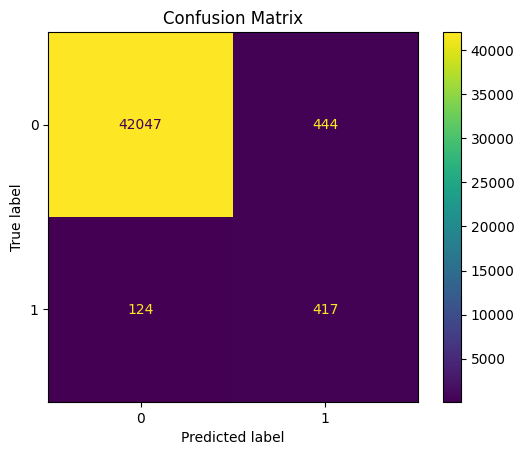

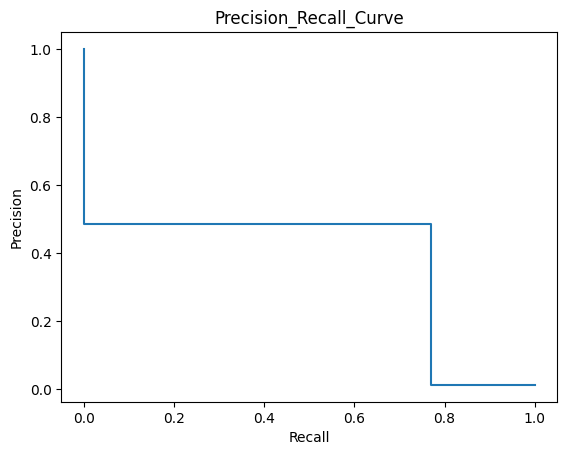

roc_auc 0.880172776394401


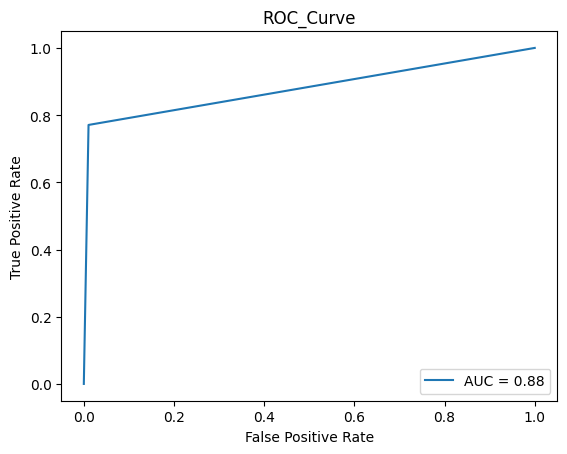

   f1_score  accuracy_score  precision_score  recall_score
0  0.594864        0.986801         0.484321      0.770795


In [12]:
torch.manual_seed(42)
criterion=nn.L1Loss(reduction='none')
ypred=model.predict(test_loader,0.02,criterion=criterion)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

#### Questions
1. Combien de couche utilisé dans notre couche d'encodeur ?
2. Quelle dimension pour la variable latente(la dimension de des donnée à la sortie des de la couche d'encodeur) ?
3. Quelle est la bonne initialisation des poids de notre réseaux (Quelle fonction utilisée) ?
4. Quel algo d'optimization utilisé (SGD, Adam, ...)?
5. Quelle fonction d'activation utilisée ?
6. Quelle pourcentage de contamination utilisé ?
7. Comment détecter des problèmes de vanishing ou exploding gradient ?

## Référence
https://arxiv.org/pdf/1805.06725.pdf <br>
https://github.com/samet-akcay/ganomaly/blob/master/options.py <br>


meiller params : w_recons=40, dropout=0.2,recons_loss=SmoothL1,  tp=421, loss_fn=L1Loss <br>
gen_loss= 1*loss_fn(z_real2,z_fake2) + 3*loss_fn(real_outputs2.to(self.device),fake_output2) + 40*recons_loss(real_data,fake_data2)